# Analysing the Data:

Importing the ODI ball by ball data from 2015 onwards

In [12]:
from pathlib import Path
import pandas as pd

# Get the project root dynamically (the parent of the notebook folder)
project_root = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path().resolve().parents[0]

# Build the path to the CSV
data_path = project_root / "data" / "odi_bbb_recent.csv"

# Read the CSV
data = pd.read_csv(data_path)

print(f"Loaded file from: {data_path}")

data.head()

C:\Users\othma\AppData\Local\Temp\ipykernel_21296\405764276.py:11: DtypeWarning: Columns (1,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


Loaded file from: C:\Github\dst_assessment1\YoussefO\data\odi_bbb_recent.csv


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,player_dismissed,other_wicket_type,other_player_dismissed,winner,toss_winner,toss_decision,team1,team2,bowling_style,batting_style
0,749781,2014/15,2015-01-11,Hagley Oval,1,0.1,Sri Lanka,New Zealand,FDM Karunaratne,TM Dilshan,...,NaN,NaN,NaN,New Zealand,Sri Lanka,bat,New Zealand,Sri Lanka,Left arm Fast medium,Left hand Bat
1,749781,2014/15,2015-01-11,Hagley Oval,1,0.2,Sri Lanka,New Zealand,TM Dilshan,FDM Karunaratne,...,NaN,NaN,NaN,New Zealand,Sri Lanka,bat,New Zealand,Sri Lanka,Left arm Fast medium,Right hand Bat
2,749781,2014/15,2015-01-11,Hagley Oval,1,0.3,Sri Lanka,New Zealand,TM Dilshan,FDM Karunaratne,...,NaN,NaN,NaN,New Zealand,Sri Lanka,bat,New Zealand,Sri Lanka,Left arm Fast medium,Right hand Bat
3,749781,2014/15,2015-01-11,Hagley Oval,1,0.4,Sri Lanka,New Zealand,TM Dilshan,FDM Karunaratne,...,NaN,NaN,NaN,New Zealand,Sri Lanka,bat,New Zealand,Sri Lanka,Left arm Fast medium,Right hand Bat
4,749781,2014/15,2015-01-11,Hagley Oval,1,0.5,Sri Lanka,New Zealand,TM Dilshan,FDM Karunaratne,...,NaN,NaN,NaN,New Zealand,Sri Lanka,bat,New Zealand,Sri Lanka,Left arm Fast medium,Right hand Bat


In [6]:
data.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'winner', 'toss_winner', 'toss_decision',
       'team1', 'team2', 'bowling_style', 'batting_style'],
      dtype='object')

In [7]:
data.shape

(620647, 29)

## Clean Data:

We remove matches with no winners (i.e. if it is a draw or matches or called off) or matches where they have not had a second innings. We also try to remove human error where there is a missing field for teams etc.

In [70]:
df = data.copy()

# Fill NAs in extras columns with 0
extras_cols = ['wides', 'noballs', 'byes', 'legbyes', 'penalty', 'extras']
for col in extras_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Fill NAs in runs_off_bat with 0
df['runs_off_bat'] = df['runs_off_bat'].fillna(0)

# Remove matches with missing critical information
before = df['match_id'].nunique()
df = df.dropna(subset=['match_id', 'innings', 'ball', 'team1', 'team2', 'winner'])

# Remove matches where winner is neither team1 nor team2
valid_winners = (df['winner'] == df['team1']) | (df['winner'] == df['team2'])
df = df[valid_winners].copy()

# Keep only matches with both innings present
innings_count = df.groupby('match_id')['innings'].nunique()
valid_matches = innings_count[innings_count == 2].index
df = df[df['match_id'].isin(valid_matches)].copy()

after = df['match_id'].nunique()
print(f"Removed {before - after} incomplete matches. Remaining: {after} matches\n")



Removed 55 incomplete matches. Remaining: 1118 matches



## Feature Engineering:
We aggregate ball-level data to match-innigs level and create specified features like identifying the number of 'fours', 'sixes' and so on. 

In [71]:


# === FEATURE ENGINEERING ===

# Convert ball to over number
df['over'] = df['ball'].astype(float).apply(lambda x: int(x))

# Calculate total runs per ball
df['total_runs'] = df['runs_off_bat'] + df['extras']

# Identify boundaries
df['is_four'] = (df['runs_off_bat'] == 4).astype(int)
df['is_six'] = (df['runs_off_bat'] == 6).astype(int)
df['is_boundary'] = ((df['runs_off_bat'] == 4) | (df['runs_off_bat'] == 6)).astype(int)

# Identify dot balls
df['is_dot'] = (df['total_runs'] == 0).astype(int)

# Identify wickets
df['is_wicket'] = df['wicket_type'].notna().astype(int)



def aggregate_match_stats(df_filtered, innings_label):
    """
    Helper function to aggregate ball-level data to match-innings level.
    """
    match_innings_stats = df_filtered.groupby(['match_id', 'innings']).agg({
        'total_runs': 'sum',
        'runs_off_bat': 'sum',
        'extras': 'sum',
        'wides': 'sum',
        'noballs': 'sum',
        'is_wicket': 'sum',
        'is_dot': 'sum',
        'is_four': 'sum',
        'is_six': 'sum',
        'is_boundary': 'sum',
        'ball': 'count'
    }).reset_index()
    
    # Rename columns
    match_innings_stats.columns = [
        'match_id', 'innings', 'total_runs', 'runs_off_bat', 'total_extras',
        'wides', 'noballs', 'wickets', 'dot_balls', 'fours', 'sixes', 
        'boundaries', 'balls_bowled'
    ]
    
    # Calculate derived metrics
    match_innings_stats['run_rate'] = (match_innings_stats['total_runs'] / 
                                        match_innings_stats['balls_bowled'] * 6)
    match_innings_stats['dot_ball_percentage'] = (match_innings_stats['dot_balls'] / 
                                                   match_innings_stats['balls_bowled'] * 100)
    match_innings_stats['boundary_percentage'] = (match_innings_stats['boundaries'] / 
                                                   match_innings_stats['balls_bowled'] * 100)
    match_innings_stats['extras_per_over'] = (match_innings_stats['total_extras'] / 
                                               (match_innings_stats['balls_bowled'] / 6))
    
    return match_innings_stats



### First 10 Overs dataset:

In [73]:
# Filter: innings 1, first 10 overs
df_innings1_10 = df[(df['innings'] == 1) & (df['over'] < 10)].copy()

# Aggregate
match_stats = aggregate_match_stats(df_innings1_10, 'team1')

# Only keep innings 1 (should only be innings 1 anyway)
match_stats = match_stats[match_stats['innings'] == 1].copy()

# Rename columns to team1_*
rename_dict = {col: f'team1_{col}' for col in match_stats.columns 
                if col not in ['match_id', 'innings']}
match_stats = match_stats.rename(columns=rename_dict).drop('innings', axis=1)

# Add match metadata
match_metadata = df.groupby('match_id').first()[
    ['season', 'start_date', 'venue', 'winner', 'toss_winner', 
        'toss_decision', 'team1', 'team2']
].reset_index()

df_10 = pd.merge(match_stats, match_metadata, on='match_id', how='left')

### First innings and first 10 Overs dataset:

In [77]:


    
# Split by innings
innings1_full = df[df['innings'] == 1].copy()
innings2_10 = df[(df['innings'] == 2) & (df['over'] < 10)].copy()

# Combine
combined = pd.concat([innings1_full, innings2_10], ignore_index=True)

# Aggregate
match_innings_stats = aggregate_match_stats(combined, 'both')

# Separate innings
innings1 = match_innings_stats[match_innings_stats['innings'] == 1].copy()
innings2 = match_innings_stats[match_innings_stats['innings'] == 2].copy()

# Rename columns
innings1_cols = {col: f'team1_{col}' for col in innings1.columns 
                    if col not in ['match_id', 'innings']}
innings2_cols = {col: f'team2_{col}' for col in innings2.columns 
                    if col not in ['match_id', 'innings']}

innings1 = innings1.rename(columns=innings1_cols).drop('innings', axis=1)
innings2 = innings2.rename(columns=innings2_cols).drop('innings', axis=1)

# Merge innings
match_features = pd.merge(innings1, innings2, on='match_id', how='inner')

# Add match metadata
match_metadata = df.groupby('match_id').first()[
    ['season', 'start_date', 'venue', 'winner', 'toss_winner', 
        'toss_decision', 'team1', 'team2']
].reset_index()

df_60 = pd.merge(match_features, match_metadata, on='match_id', how='left')

Now we maked a function that adds binary outcomes to our data so that we can easily train a model on it. We also categorise the teams and venues so that we can have more information to predict the outcome with.

In [ ]:
def categorize_features(df):
    """
    Add binary outcomes, toss variables, difference metrics, and categorical encodings.
    """
    
    final_data = df.copy()
    
    # Binary winner variable (1 if team1 wins, 0 if team2 wins)
    final_data['winner_binary'] = (final_data['winner'] == final_data['team1']).astype(int)
    
    # Toss winner binary (1 if team1 won toss, 0 otherwise)
    final_data['toss_won_by_team1'] = (final_data['toss_winner'] == final_data['team1']).astype(int)
    
    # Toss decision binary (1 if bat first, 0 if field first)
    final_data['toss_decision_bat'] = (final_data['toss_decision'] == 'bat').astype(int)
    
    # Calculate relative performance metrics (only if team2 data exists)
    has_team2 = 'team2_total_runs' in final_data.columns
    
    if has_team2:
        final_data['runs_difference'] = final_data['team1_total_runs'] - final_data['team2_total_runs']
        final_data['wickets_difference'] = final_data['team1_wickets'] - final_data['team2_wickets']
        final_data['run_rate_difference'] = final_data['team1_run_rate'] - final_data['team2_run_rate']
        final_data['boundary_difference'] = final_data['team1_boundaries'] - final_data['team2_boundaries']
        print("  Added difference metrics (team1 - team2)")
    else:
        print("  Skipped difference metrics (no team2 data)")
    
    # Create venue and team categorical encodings (for mixed effects)
    final_data['venue_encoded'] = pd.Categorical(final_data['venue']).codes
    final_data['team1_encoded'] = pd.Categorical(final_data['team1']).codes
    final_data['team2_encoded'] = pd.Categorical(final_data['team2']).codes
    final_data['season_encoded'] = pd.Categorical(final_data['season']).codes
    
    # Sort by match_id for consistency
    final_data = final_data.sort_values('match_id').reset_index(drop=True)
    
    return final_data



  Skipped difference metrics (no team2 data)
  Added difference metrics (team1 - team2)


In [ ]:

# Apply categorization to both datasets   

df_10 = categorize_features(df_10)
df_60 = categorize_features(df_60)

In [79]:
df_10.head(1)

,match_id,team1_total_runs,team1_runs_off_bat,team1_total_extras,team1_wides,team1_noballs,team1_wickets,team1_dot_balls,team1_fours,team1_sixes,...,toss_decision,team1,team2,winner_binary,toss_won_by_team1,toss_decision_bat,venue_encoded,team1_encoded,team2_encoded,season_encoded
0,656399,77,71,6,2.0,2.0,0,31,10,1,...,field,New Zealand,Sri Lanka,1,0,0,65,11,17,2


In [80]:
df_60.head(1)

,match_id,team1_total_runs,team1_runs_off_bat,team1_total_extras,team1_wides,team1_noballs,team1_wickets,team1_dot_balls,team1_fours,team1_sixes,...,toss_won_by_team1,toss_decision_bat,runs_difference,wickets_difference,run_rate_difference,boundary_difference,venue_encoded,team1_encoded,team2_encoded,season_encoded
0,656399,331,318,13,8.0,3.0,6,129,34,4,...,0,0,285,6,1.785852,31,65,11,17,2


# Investigating the Data to determine Fixed Effects:

In the following we find which fixed effects to include and then we move into R for our random effects selection.

We now look at which fixed effects to include by analyzing their correlations and removing multicollinear variables.

 The function checks for highly correlated metric pairs above a chosen threshold and reports the top 15 predictors most correlated with the match outcome. This helps reduce the dimensionality of the dataset and ensures that only the most informative and non-redundant variables are used as fixed effects in the model.


In [109]:


def analyze_fixed_effects(df, threshold=0.8):
    """
    Analyze fixed effect candidates and check for multicollinearity.
    """

    
    # Get performance metrics
    performance_metrics = [
        'team1_total_runs', 'team2_total_runs', 'runs_difference',
        'team1_wickets', 'team2_wickets', 'wickets_difference',
        'team1_run_rate', 'team2_run_rate', 'run_rate_difference',
        'team1_boundaries', 'team2_boundaries', 'boundary_difference',
        'team1_dot_ball_percentage', 'team2_dot_ball_percentage',
        'team1_fours', 'team2_fours', 'team1_sixes', 'team2_sixes',
        'team1_total_extras', 'team2_total_extras'
    ]
    
    available_metrics = [col for col in performance_metrics if col in df.columns]
    
    toss_variables = ['toss_won_by_team1', 'toss_decision_bat']
    available_metrics.extend([col for col in toss_variables if col in df.columns])
    
    print(f"Available metrics: {len(available_metrics)}")
    
    # Correlation matrix
    correlation_matrix = df[available_metrics].corr()
    
    print(f"\nHighly correlated pairs (|r| > {threshold}):")
    
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                high_corr_pairs.append({
                    'var1': var1,
                    'var2': var2,
                    'correlation': corr_value
                })
                print(f"  {var1} <-> {var2}: r = {corr_value:.3f}")
    
    if not high_corr_pairs:
        print("  None found")
    
    # Correlation with outcome
    print("\nCorrelation with winner (top 15):")
    
    target_correlations = df[available_metrics].corrwith(df['winner_binary']).abs().sort_values(ascending=False)
    
    for i, (var, corr) in enumerate(target_correlations.head(15).items(), 1):
        print(f"  {i}. {var}: |r| = {corr:.3f}")
    
    plt.figure(figsize=(14,12))
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    plt.close()
    

    



Available metrics: 10

Highly correlated pairs (|r| > 0.8):
  team1_total_runs <-> team1_run_rate: r = 0.996
  team1_total_runs <-> team1_boundaries: r = 0.898
  team1_total_runs <-> team1_dot_ball_percentage: r = -0.834
  team1_total_runs <-> team1_fours: r = 0.813
  team1_run_rate <-> team1_boundaries: r = 0.904
  team1_run_rate <-> team1_dot_ball_percentage: r = -0.827
  team1_run_rate <-> team1_fours: r = 0.819
  team1_boundaries <-> team1_fours: r = 0.949

Correlation with winner (top 15):
  1. team1_wickets: |r| = 0.195
  2. team1_total_runs: |r| = 0.162
  3. team1_run_rate: |r| = 0.162
  4. team1_dot_ball_percentage: |r| = 0.161
  5. team1_boundaries: |r| = 0.131
  6. team1_fours: |r| = 0.112
  7. team1_sixes: |r| = 0.095
  8. toss_won_by_team1: |r| = 0.015
  9. team1_total_extras: |r| = 0.003
  10. toss_decision_bat: |r| = 0.002


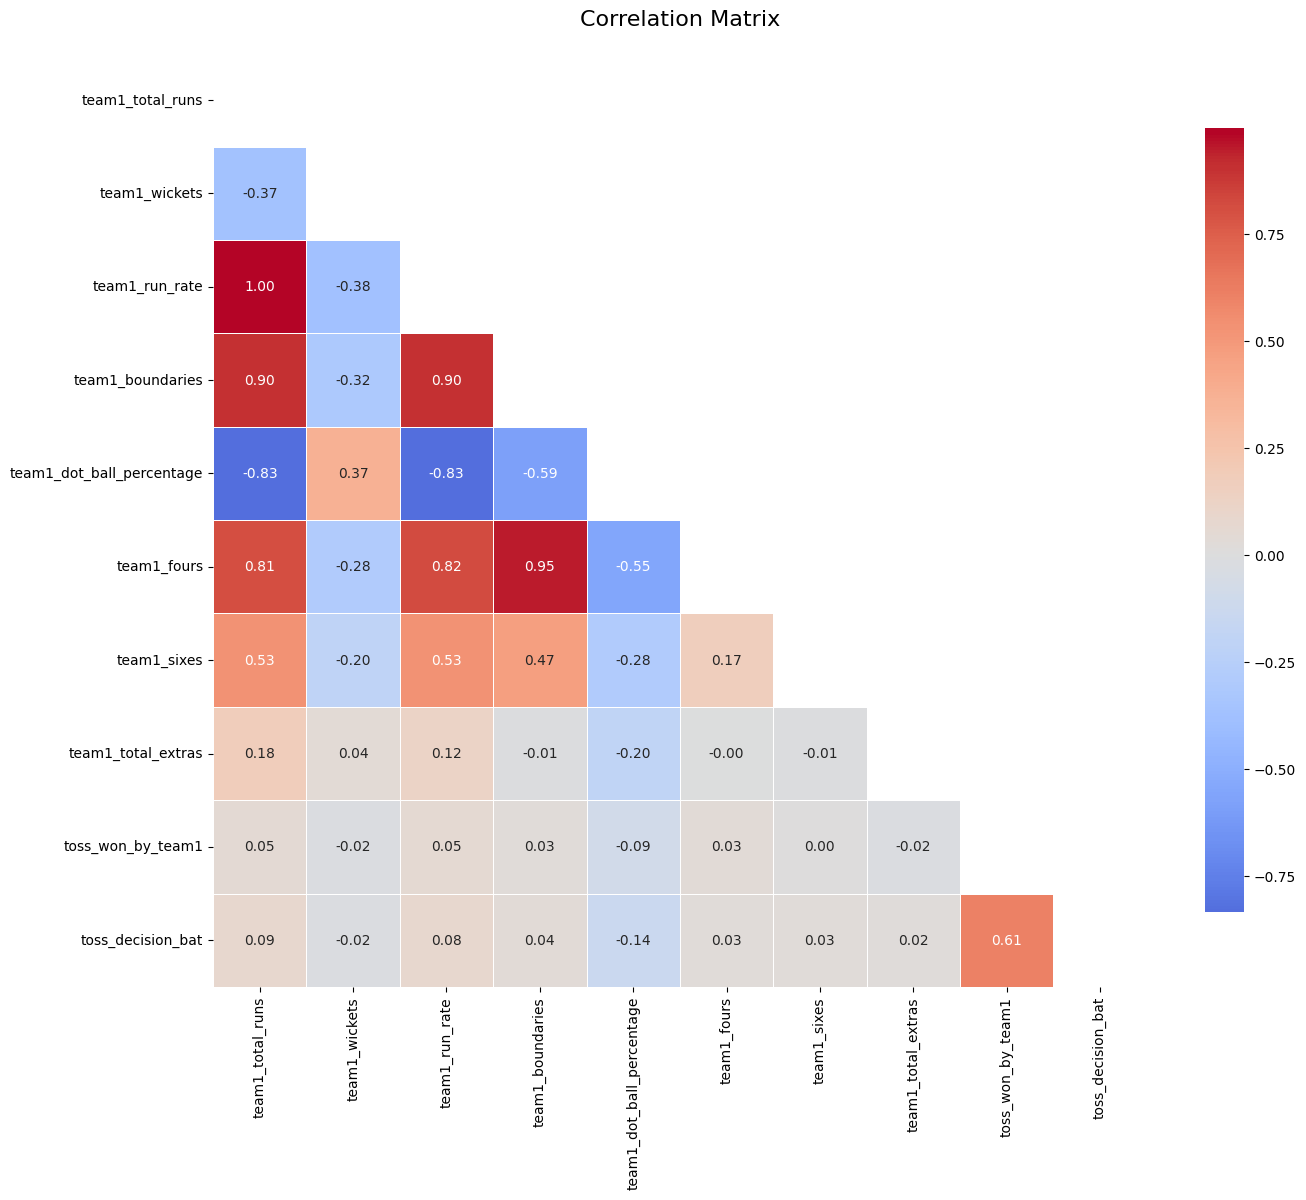

In [110]:


analyze_fixed_effects(df_10)

From the correlation analysis, several metrics such as total runs, run rate, boundaries, and dot ball percentage were found to be highly collinear. 
For example, total runs and run rate were almost perfectly correlated, while boundaries and fours showed strong redundancy. To avoid multicollinearity, we kept only a subset of non-redundant predictors that still capture key aspects of early batting performance. 

The selected fixed effects:
 - team1_wickets
 - team1_dot_ball_percentage
 - team1_run_rate.

represent complementary dimensions of performance:  
- stability (wicket loss)
- scoring efficiency (run rate)
- control of play (dot ball frequency). 
  
These variables summarize team performance in the first 10 overs without overlapping information.

Available metrics: 22

Highly correlated pairs (|r| > 0.8):
  team1_total_runs <-> runs_difference: r = 0.975
  team1_total_runs <-> team1_run_rate: r = 0.932
  team1_total_runs <-> team1_boundaries: r = 0.911
  team1_total_runs <-> boundary_difference: r = 0.879
  team1_total_runs <-> team1_dot_ball_percentage: r = -0.893
  team1_total_runs <-> team1_fours: r = 0.837
  team2_total_runs <-> team2_run_rate: r = 0.988
  team2_total_runs <-> team2_boundaries: r = 0.911
  team2_total_runs <-> team2_dot_ball_percentage: r = -0.840
  runs_difference <-> team1_run_rate: r = 0.887
  runs_difference <-> team1_boundaries: r = 0.874
  runs_difference <-> boundary_difference: r = 0.909
  runs_difference <-> team1_dot_ball_percentage: r = -0.860
  runs_difference <-> team1_fours: r = 0.807
  team1_wickets <-> wickets_difference: r = 0.862
  team1_run_rate <-> team1_boundaries: r = 0.913
  team1_run_rate <-> boundary_difference: r = 0.861
  team1_run_rate <-> team1_dot_ball_percentage: r = -0.898
  

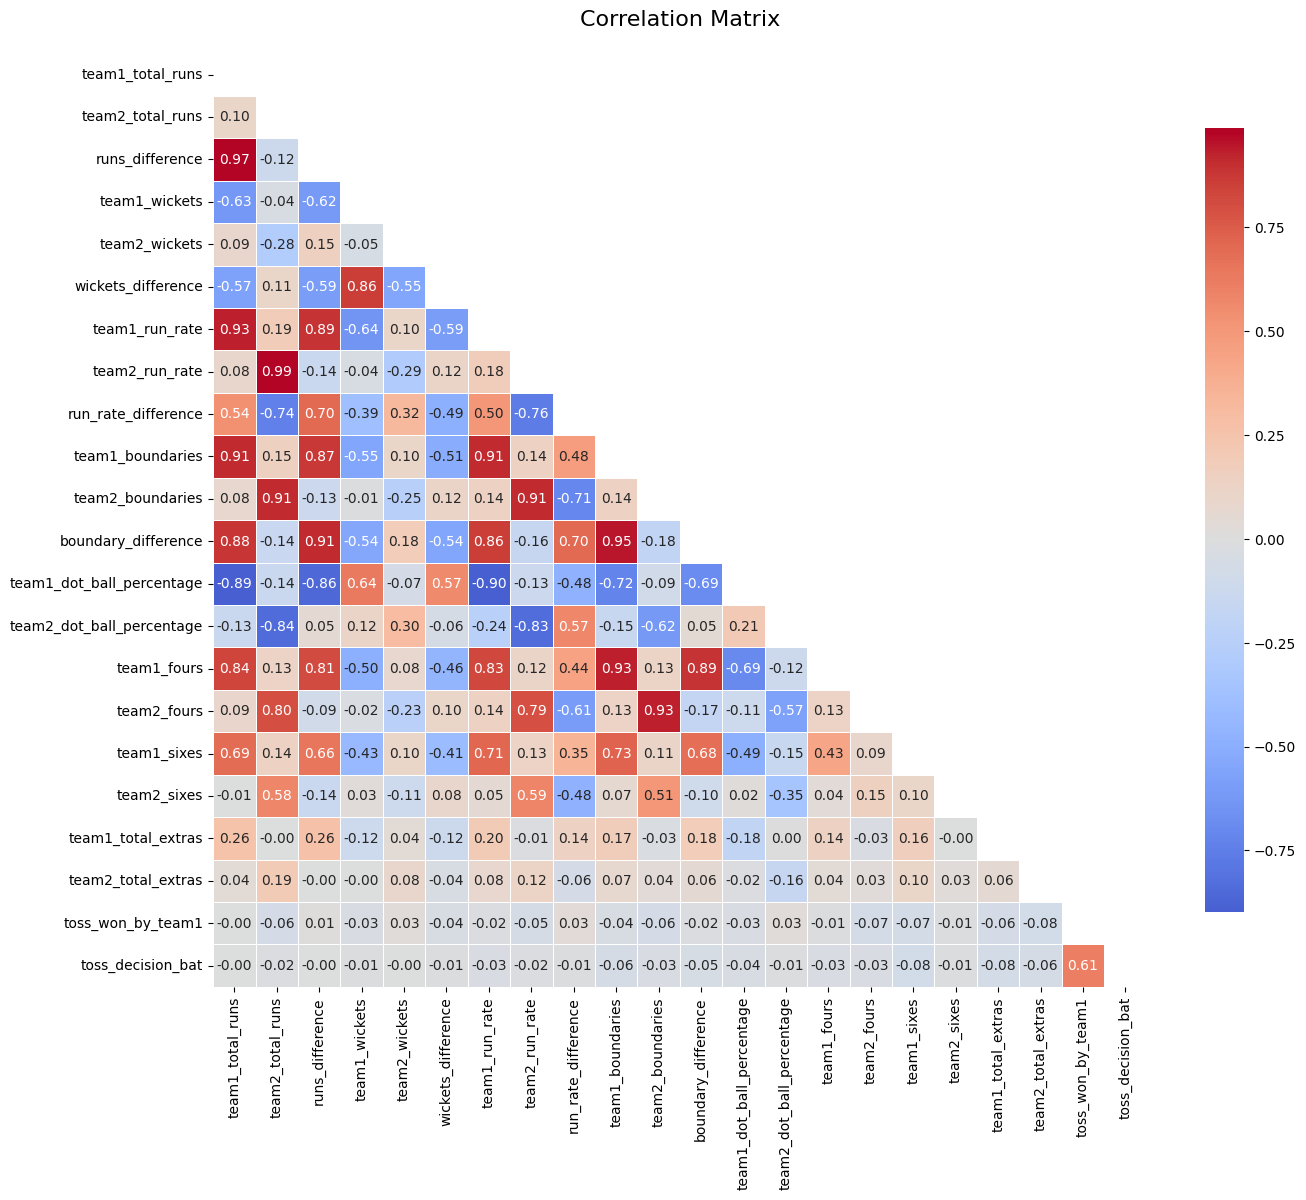

In [111]:
analyze_fixed_effects(df_60)

For the extended dataset, which now includes the entire first innings and the first 10 overs of the second team, we observe stronger relationships between several performance metrics. 

In particular, total runs, run rate, and boundaries remain highly correlated, while the introduction of difference-based variables (such as runs_difference and wickets_difference) adds additional redundancy. 

To avoid overlap, we selected a compact set of fixed effects: 
- runs_difference  (offensive dominance)
- wickets_difference  (bowling success)
- team1_dot_ball_percentage  (economic bowling)
- run_rate_differnce  (scoring strategy : go hard vs. be safe)
- toss_won_by_team1 (Strategy)

These variables capture the balance of Batting, Bowling, Defense and Strategy in Cricket.

## Selected Variables:

In [ ]:
fixed_effects10 = [
        # Outcome
        'winner_binary',
        
        # Random effects
        'season',
        'team1',
        'team2',
        'venue',
        
        
        # Fixed effects - individual team metrics
        'team1_wickets',
        'team1_dot_ball_percentage',
        'team1_run_rate',
        
        # Keep match_id for reference
        'match_id'
    ]

fixed_effects60 = [
        # Outcome
        'winner_binary',
        
        # Random effects
        'season',
        'team1',
        'team2',
        'venue',
        
        # Fixed effects
        'runs_difference',
        'wickets_difference',
        'team1_dot_ball_percentage',
        'run_rate_difference',
        'toss_won_by_team1',
'

        # Keep match_id for reference
        'match_id'
    ]
# Create modeling dataset
modeling_data1 = df_10[fixed_effects10].copy()
modeling_data2 = df_60[fixed_effects60].copy()


## Saving our Dataframe to a CSV file:

We now move our work to R, as there exists better tools for implementation via the ```glmer``` function in the ```lme4``` package. This is also where we will decide which of the random effects we wil include.

In [ ]:
#Make sure categorical variables are strings before exporting to CSV
# This ensures R reads them as categorical variables

modeling_data1['season'] = modeling_data1['season'].astype(str)
modeling_data1['team1'] = modeling_data1['team1'].astype(str)
modeling_data1['team2'] = modeling_data1['team2'].astype(str)
modeling_data1['venue'] = modeling_data1['venue'].astype(str)
modeling_data1.to_csv("cricket_model_data_10.csv", index=False)

modeling_data2['season'] = modeling_data2['season'].astype(str)
modeling_data2['team1'] = modeling_data2['team1'].astype(str)
modeling_data2['team2'] = modeling_data2['team2'].astype(str)
modeling_data2['venue'] = modeling_data2['venue'].astype(str)
modeling_data2.to_csv("cricket_model_data_60.csv", index=False)
